# Deep learning for computer vision


# CIFAR dataset
* 60k images of shape 3x32x32
* 10 different classes: planes, dogs, cats, trucks, etc.

<img src="https://github.com/yandexdataschool/Practical_DL/blob/fall23/week03_convnets/cifar10.jpg?raw=1" style="width:80%">

In [1]:
# when running in colab, un-comment this
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall19/week03_convnets/cifar.py

--2024-12-15 03:46:06--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall19/week03_convnets/cifar.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2396 (2.3K) [text/plain]
Saving to: ‘cifar.py’

cifar.py            100%[===================>]   2.34K  --.-KB/s    in 0s      

2024-12-15 03:46:06 (44.1 MB/s) - ‘cifar.py’ saved [2396/2396]



In [2]:
import numpy as np
from cifar import load_cifar10
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10()

class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer',
                        'dog', 'frog', 'horse', 'ship', 'truck'])

print(X_train.shape,y_train.shape)

Dataset not found. Downloading...
(40000, 3, 32, 32) (40000,)


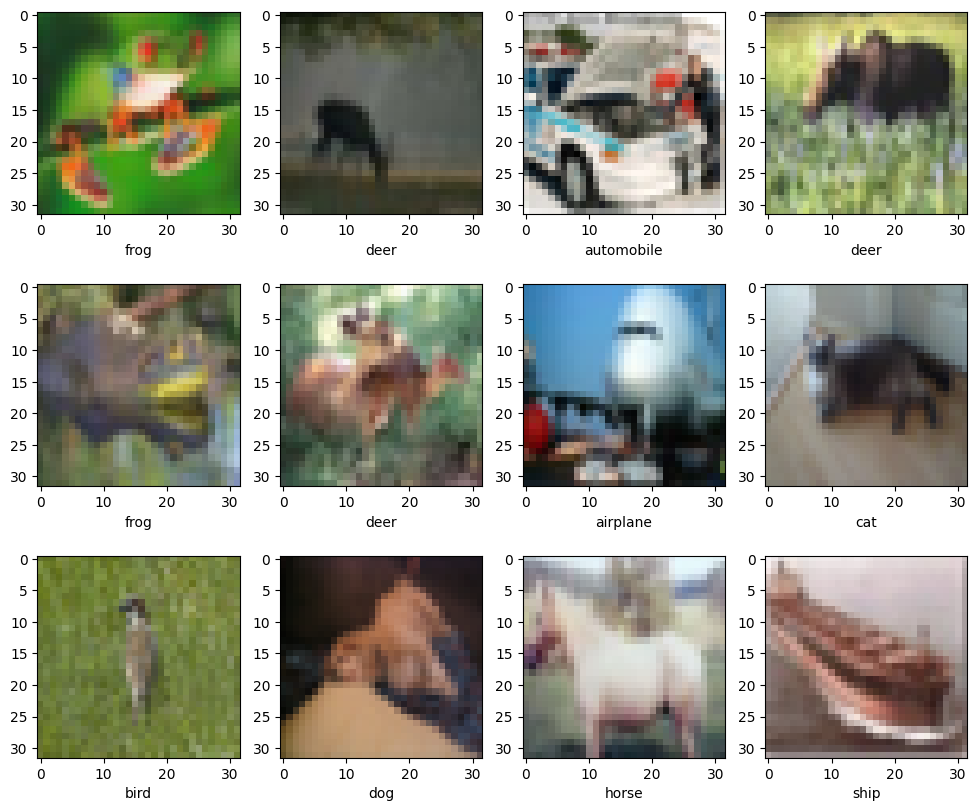

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.xlabel(class_names[y_train[i]])
    plt.imshow(np.transpose(X_train[i],[1,2,0]))

# Building a network

Simple neural networks with layers applied on top of one another implemented with pytorch as `torch.nn.Sequential`.

In [4]:
import torch, torch.nn as nn
import torch.nn.functional as F

# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

Starting with a dense network for our baseline:

In [5]:
model = nn.Sequential()

# reshape from "images" to flat vectors
model.add_module('flatten', Flatten())

# dense "head"
model.add_module('dense1', nn.Linear(3 * 32 * 32, 64))
model.add_module('dense1_relu', nn.ReLU())
model.add_module('dense2_logits', nn.Linear(64, 10)) # logits for 10 classes

We train model with negative log-likelihood aka crossentropy.

In [6]:
def compute_loss(X_batch, y_batch):
    X_batch = torch.as_tensor(X_batch, dtype=torch.float32)
    y_batch = torch.as_tensor(y_batch, dtype=torch.int64)
    logits = model(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

In [7]:
# example
compute_loss(X_train[:5], y_train[:5])

tensor(2.3918, grad_fn=<MeanBackward0>)

### Training on minibatches
* We got 40k images, that's way too many for a full-batch SGD. Let's train on minibatches instead
* Below is a function that splits the training sample into minibatches

In [8]:
# An auxilary function that returns mini-batches for neural network training
def iterate_minibatches(X, y, batchsize):
    indices = np.random.permutation(np.arange(len(X)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

In [9]:
opt = torch.optim.SGD(model.parameters(), lr=0.01)

train_loss = []
val_accuracy = []

In [10]:
# Model training

import time
num_epochs = 25 # total amount of full passes over training data
batch_size = 50  # number of samples processed in one SGD iteration

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.numpy())

    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
        logits = model(torch.as_tensor(X_batch, dtype=torch.float32))
        y_pred = logits.max(1)[1].data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))


    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

Epoch 1 of 25 took 2.081s
  training loss (in-iteration): 	2.036719
  validation accuracy: 			33.74 %
Epoch 2 of 25 took 1.579s
  training loss (in-iteration): 	1.858368
  validation accuracy: 			37.85 %
Epoch 3 of 25 took 1.421s
  training loss (in-iteration): 	1.791076
  validation accuracy: 			37.65 %
Epoch 4 of 25 took 1.446s
  training loss (in-iteration): 	1.742249
  validation accuracy: 			39.93 %
Epoch 5 of 25 took 1.433s
  training loss (in-iteration): 	1.703247
  validation accuracy: 			40.93 %
Epoch 6 of 25 took 1.469s
  training loss (in-iteration): 	1.669042
  validation accuracy: 			42.32 %
Epoch 7 of 25 took 1.503s
  training loss (in-iteration): 	1.641196
  validation accuracy: 			42.16 %
Epoch 8 of 25 took 1.478s
  training loss (in-iteration): 	1.614017
  validation accuracy: 			43.77 %
Epoch 9 of 25 took 1.840s
  training loss (in-iteration): 	1.594538
  validation accuracy: 			44.48 %
Epoch 10 of 25 took 1.860s
  training loss (in-iteration): 	1.576217
  validation 



```

```

```

### Final test

In [11]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
    logits = model(torch.as_tensor(X_batch, dtype=torch.float32))
    y_pred = logits.max(1)[1].data.numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)

print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'17. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		47.82 %
We need more magic! Follow instructons below


## A small convolution net
### First step

Let's create a mini-convolutional network with roughly such architecture:
* Input layer
* 3x3 convolution with 10 filters and _ReLU_ activation
* 2x2 pooling (or set previous convolution stride to 3)
* Flatten
* Dense layer with 100 neurons and _ReLU_ activation
* 10% dropout
* Output dense layer.


__Convolutional layers__ in torch are just like all other layers, but with a specific set of parameters:

__`...`__

__`model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)) # convolution`__

__`model.add_module('pool1', nn.MaxPool2d(2)) # max pooling 2x2`__

__`...`__


In [12]:
import torch
import torch.nn as nn

# Define the model
model = nn.Sequential()

# First Convolutional Block
model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, padding=1))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(2))  # Max pooling 2x2

# Second Convolutional Block
model.add_module('conv2', nn.Conv2d(in_channels=10, out_channels=128, kernel_size=3, padding=1))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(2))  # Max pooling 2x2


# Flattening
model.add_module('flatten', nn.Flatten())

# Fully Connected Layers
model.add_module('dense1', nn.Linear(8192, 100))  # Adjust input size based on the previous layer
model.add_module('relu2', nn.ReLU())
model.add_module('dropout', nn.Dropout(0.1))  # 10% dropout
model.add_module('dense2_logits', nn.Linear(100, 10))  # Output layer

# print(model)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Sequential(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense1): Linear(in_features=8192, out_features=100, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (dense2_logits): Linear(in_features=100, out_features=10, bias=True)
)

In [14]:
# Data transformations
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10("cifar_data")

class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer',
                        'dog', 'frog', 'horse', 'ship', 'truck'])

print(X_test.shape,y_test.shape)
# printout must be (40000, 3, 32, 32) (40000,)

X_train = torch.from_numpy(X_train).float().to(device)
y_train = torch.from_numpy(y_train).long().to(device)
X_batch_tensor = torch.as_tensor(X_batch, dtype=torch.float32).to(device)
y_batch_tensor = torch.as_tensor(y_batch, dtype=torch.int64).to(device)

Dataset not found. Downloading...
(10000, 3, 32, 32) (10000,)


In [15]:
# Compute loss function
def compute_loss(X_batch, y_batch):
    X_batch = torch.as_tensor(X_batch, dtype=torch.float32)
    y_batch = torch.as_tensor(y_batch, dtype=torch.int64)
    logits = model(X_batch)
    return F.cross_entropy(logits, y_batch).mean()


# Test loss function
compute_loss(X_train[:5], y_train[:5])

tensor(2.2888, device='cuda:0', grad_fn=<MeanBackward0>)

In [16]:
# Optimizer with Adam
opt = torch.optim.Adam(model.parameters(), lr=0.001)

train_loss = []
val_accuracy = []

In [17]:
# Training Phase

import time
num_epochs = 25  # total amount of full passes over training data
batch_size = 50  # number of samples processed in one SGD iteration

for epoch in range(num_epochs):
    start_time = time.time()

    # Training mode
    model.train(True)
    # remove this tensor conversion because compute error doing it already
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        # Move data to GPU
        X_batch = torch.as_tensor(X_batch, dtype=torch.float32).to(device)
        y_batch = torch.as_tensor(y_batch, dtype=torch.long).to(device)

        # Compute loss and backpropagate
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()

        # Append training loss
        train_loss.append(loss.item())

    # Evaluation on validation data
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
            # Move data to GPU
            X_batch = torch.as_tensor(X_batch, dtype=torch.float32).to(device)
            y_batch = torch.as_tensor(y_batch, dtype=torch.long).to(device)

            # Forward pass and prediction
            logits = model(X_batch)
            y_pred = logits.max(1)[1].cpu().numpy()
            val_accuracy.append(np.mean(y_batch.cpu().numpy() == y_pred))

    # Print the results for the current epoch
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size:])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size:]) * 100))


Epoch 1 of 25 took 2.755s
  training loss (in-iteration): 	1.480411
  validation accuracy: 			57.45 %
Epoch 2 of 25 took 2.415s
  training loss (in-iteration): 	1.105518
  validation accuracy: 			63.64 %
Epoch 3 of 25 took 2.494s
  training loss (in-iteration): 	0.955867
  validation accuracy: 			65.10 %
Epoch 4 of 25 took 2.273s
  training loss (in-iteration): 	0.854591
  validation accuracy: 			66.11 %
Epoch 5 of 25 took 2.280s
  training loss (in-iteration): 	0.775118
  validation accuracy: 			67.03 %
Epoch 6 of 25 took 2.262s
  training loss (in-iteration): 	0.697054
  validation accuracy: 			66.65 %
Epoch 7 of 25 took 2.308s
  training loss (in-iteration): 	0.633185
  validation accuracy: 			68.04 %
Epoch 8 of 25 took 2.552s
  training loss (in-iteration): 	0.569278
  validation accuracy: 			67.59 %
Epoch 9 of 25 took 2.274s
  training loss (in-iteration): 	0.517855
  validation accuracy: 			67.79 %
Epoch 10 of 25 took 2.286s
  training loss (in-iteration): 	0.462734
  validation 

In [18]:
# Test Phase

model.eval() # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
    logits = model(torch.as_tensor(X_batch, dtype=torch.float32).to(device))
    y_pred = logits.max(1)[1].data.cpu().numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)

print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'17. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		64.57 %
Achievement unlocked: 70lvl Warlock!


```

```

```

```

```

```

```

```

```

```


## Adding normalization

* Add batch norm (with default params) between convolution and ReLU
  * nn.BatchNorm*d (1d for dense, 2d for conv)
* Re-train the network with the same optimizer to get at least 60% validation accuracy at peak.



In [19]:
# Added batch normalizations

model_v2 = nn.Sequential(
    model[0],
    nn.BatchNorm2d(10),
    model[1],
    model[2],
    model[3],
    nn.BatchNorm2d(128),
    model[4],
    model[5],
    model[6],
    model[7],
    nn.BatchNorm1d(100),
    model[8],
    model[9]
)

# Reload updated model to device
model_v2.to(device)
print(model_v2)

Sequential(
  (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(10, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=8192, out_features=100, bias=True)
  (10): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): Dropout(p=0.1, inplace=False)
  (12): Linear(in_features=100, out_features=10, bias=True)
)


In [20]:
# Reload data
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10("cifar_data")

class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer',
                        'dog', 'frog', 'horse', 'ship', 'truck'])

# Reinit optimizer and eval list
opt = torch.optim.Adam(model_v2.parameters(), lr=0.001)

train_loss = []
val_accuracy = []

# Training Phase

import time
num_epochs = 25
batch_size = 50
for epoch in range(num_epochs):
    start_time = time.time()

    # Training mode
    model_v2.train(True)  # enable dropout

    # Iterate over mini-batches of training data
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        # Move data to GPU
        X_batch = torch.as_tensor(X_batch, dtype=torch.float32).to(device)
        y_batch = torch.as_tensor(y_batch, dtype=torch.long).to(device)

        # Compute loss and backpropagate
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()

        # Append training loss
        train_loss.append(loss.item())

    # Evaluation on validation data
    model_v2.eval()
    with torch.no_grad():
        for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
            # Move data to GPU
            X_batch = torch.as_tensor(X_batch, dtype=torch.float32).to(device)
            y_batch = torch.as_tensor(y_batch, dtype=torch.long).to(device)

            # Forward pass and prediction
            logits = model_v2(X_batch)
            y_pred = logits.max(1)[1].cpu().numpy()  # Move predictions back to CPU
            val_accuracy.append(np.mean(y_batch.cpu().numpy() == y_pred))  # Move ground truth to CPU

    # Print the results for the current epoch
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size:])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size:]) * 100))


Epoch 1 of 25 took 2.545s
  training loss (in-iteration): 	0.172667
  validation accuracy: 			64.29 %
Epoch 2 of 25 took 2.496s
  training loss (in-iteration): 	0.150732
  validation accuracy: 			64.50 %
Epoch 3 of 25 took 2.644s
  training loss (in-iteration): 	0.148387
  validation accuracy: 			64.10 %
Epoch 4 of 25 took 2.626s
  training loss (in-iteration): 	0.134219
  validation accuracy: 			63.33 %
Epoch 5 of 25 took 2.475s
  training loss (in-iteration): 	0.149710
  validation accuracy: 			63.98 %
Epoch 6 of 25 took 2.499s
  training loss (in-iteration): 	0.132834
  validation accuracy: 			64.51 %
Epoch 7 of 25 took 2.494s
  training loss (in-iteration): 	0.135549
  validation accuracy: 			63.44 %
Epoch 8 of 25 took 2.741s
  training loss (in-iteration): 	0.126039
  validation accuracy: 			63.64 %
Epoch 9 of 25 took 2.575s
  training loss (in-iteration): 	0.120802
  validation accuracy: 			64.57 %
Epoch 10 of 25 took 2.494s
  training loss (in-iteration): 	0.131619
  validation 

In [21]:
# Test Phase

model_v2.eval()
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
    logits = model_v2(torch.as_tensor(X_batch, dtype=torch.float32).to(device))
    y_pred = logits.max(1)[1].data.cpu().numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)

print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'17. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		64.17 %
Achievement unlocked: 70lvl Warlock!



```

```

```

```

```

```

```

```

```

```

```

```

```

```
## Data Augmentation

Using a torch tool for image preprocessing to do data preprocessing and augmentation.

Works as defining a pipeline that
* makes random crops of data (augmentation)
* randomly flips image horizontally (augmentation)
* then normalizes it (preprocessing)

In [22]:
from torchvision import transforms

means = np.array((0.4914, 0.4822, 0.4465))
stds = np.array((0.2023, 0.1994, 0.2010))

transform_augment = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation([-30, 30]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

In [23]:
from torchvision.datasets import CIFAR10

train_loader = CIFAR10("./cifar_data/", train=True, download=True, transform=transform_augment)

train_batch_gen = torch.utils.data.DataLoader(train_loader,
                                              batch_size=32,
                                              shuffle=True,
                                              num_workers=1)

# for idx, (x_batch, y_batch) in enumerate(train_batch_gen):
#     print('X:', type(x_batch), x_batch.shape)
#     print('y:', type(y_batch), y_batch.shape)

Files already downloaded and verified


In [24]:
# Test transform
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

test_loader = CIFAR10("./cifar_data/", train = False,  transform=transform_test)
test_batch_gen = torch.utils.data.DataLoader(test_loader,
                                              batch_size=32,
                                              shuffle=False,
                                              num_workers=1)

# for idx, (x_batch, y_batch) in enumerate(test_batch_gen):
#     print('X:', type(x_batch), x_batch.shape)
#     print('y:', type(y_batch), y_batch.shape)

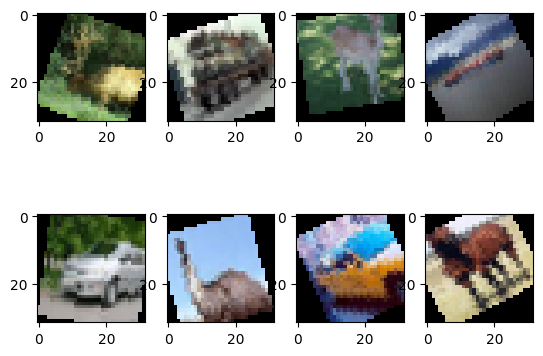

Epoch 1 of 25 took 64.239s
  training loss (in-iteration): 	8.191915
  validation accuracy: 			30.21 %
Epoch 2 of 25 took 65.432s
  training loss (in-iteration): 	5.017690
  validation accuracy: 			32.72 %
Epoch 3 of 25 took 63.130s
  training loss (in-iteration): 	3.922071
  validation accuracy: 			34.90 %
Epoch 4 of 25 took 63.890s
  training loss (in-iteration): 	3.346762
  validation accuracy: 			37.38 %
Epoch 5 of 25 took 63.377s
  training loss (in-iteration): 	2.976703
  validation accuracy: 			39.81 %
Epoch 6 of 25 took 62.753s
  training loss (in-iteration): 	2.713178
  validation accuracy: 			42.03 %
Epoch 7 of 25 took 63.623s
  training loss (in-iteration): 	2.516495
  validation accuracy: 			43.86 %
Epoch 8 of 25 took 66.314s
  training loss (in-iteration): 	2.362824
  validation accuracy: 			45.36 %
Epoch 9 of 25 took 63.440s
  training loss (in-iteration): 	2.239033
  validation accuracy: 			46.57 %
Epoch 10 of 25 took 68.878s
  training loss (in-iteration): 	2.137996
  v

In [25]:
# Reinit optimizer and eval list
opt = torch.optim.Adam(model_v2.parameters(), lr=0.001)

train_loss = []
val_accuracy = []

# Training Phase
import time
num_epochs = 25  # total amount of full passes over training data
batch_size = 50  # number of samples processed in one SGD iteration

for epoch in range(num_epochs):
    start_time = time.time()

    # Training mode
    model_v2.train(True)
    for batch_idx, (x_batch, y_batch) in enumerate(train_batch_gen):
# tako out tensor conversion
        X_batch = torch.as_tensor(x_batch, dtype=torch.float32).to(device)
        y_batch = torch.as_tensor(y_batch, dtype=torch.long).to(device)

        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss.append(loss.item())

        if epoch == 0 and batch_idx == 0:
            for i, img in enumerate(x_batch.numpy()[:8]):
                img = img.transpose([1, 2, 0]) * stds + means
                img = np.clip(img, 0, 1)
                plt.subplot(2, 4, i+1)
                plt.imshow(img)
            plt.show()

    # Evaluation on validation data
    model_v2.train(False)
    with torch.no_grad():
        for idx, (x_batch, y_batch) in enumerate(train_batch_gen):

            X_batch = torch.as_tensor(x_batch, dtype=torch.float32).to(device)
            y_batch = torch.as_tensor(y_batch, dtype=torch.long).to(device)

            logits = model_v2(X_batch)
            y_pred = logits.max(1)[1].cpu().numpy()
            val_accuracy.append(np.mean(y_batch.cpu().numpy() == y_pred))

      # Print the results for the current epoch
    epoch_time = time.time() - start_time  # Calculate epoch duration
    print(f"Epoch {epoch + 1} of {num_epochs} took {epoch_time:.3f}s")
    print(f"  training loss (in-iteration): \t{np.mean(train_loss):.6f}")  # Print mean training loss for the epoch
    print(f"  validation accuracy: \t\t\t{np.mean(val_accuracy) * 100:.2f} %")  # Print mean validation accuracy for the epoch


In [26]:
# Test Phase

model_v2.eval()
test_batch_acc = []

for batch_idx, (X_batch, y_batch) in enumerate(test_batch_gen):
    X_batch = torch.as_tensor(X_batch, dtype=torch.float32).to(device)
    y_batch = torch.as_tensor(y_batch).to(device)

    with torch.no_grad():
        logits = model_v2(X_batch)

    # Get predictions
    y_pred = logits.argmax(dim=1).cpu().numpy()
    y_batch = y_batch.cpu().numpy()

    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)

print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'17. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		67.74 %
Achievement unlocked: 70lvl Warlock!


# The Quest For A Better Network

building a monster network to solve CIFAR10 image classification.

(please read it at least diagonally)

* The ultimate quest is to create a network that has as high __accuracy__ as possible.

    
## Restrictions
* To NOT use pre-trained networks for this the task here.
  
```


### Model Packages Set Up

In [27]:
# IMPORT packages
# ! pip install timm torcheval tqdm

import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import ImageFolder
# import timm

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

System Version: 3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]
PyTorch version 2.5.1+cu121
Torchvision version 0.20.1+cu121
Numpy version 1.26.4
Pandas version 2.2.2


In [28]:
# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

#### Data Pipeline Mgr

In [29]:
# define TRANSFORMATIONS

means = np.array((0.4914, 0.4822, 0.4465))
stds = np.array((0.2023, 0.1994, 0.2010))

transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomApply([
        transforms.RandomAffine(degrees=30, translate=(0.2, 0.2)),
        transforms.RandomRotation(30),
        transforms.GaussianBlur(kernel_size=25),
    ], p=0.5),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

In [30]:
# Load CIFAR-10 dataset with the defined transformations
train_loader = CIFAR10(root="./cifar_data/", train=True, download=True, transform=transform)
val_loader = CIFAR10(root="./cifar_data/", train=False, download=True, transform=transform_val)

Files already downloaded and verified
Files already downloaded and verified


In [31]:
# Batch size
batch_size = 100

# DataLoader for the training dataset
trainset = DataLoader(train_loader,
                      batch_size=batch_size,
                      shuffle=True,
                      num_workers=2)

# DataLoader for validation/test dataset
valset = DataLoader(val_loader,
                    batch_size=batch_size,
                    shuffle=False,
                    num_workers=2)

#### CNN Model Definition

In [32]:
# Initialize customer cnn model

v8_model = nn.Sequential()

# 1st conv layer
v8_model.add_module("conv1", nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1))
v8_model.add_module("bn1", nn.BatchNorm2d(64))
v8_model.add_module('relu1', nn.ReLU())
v8_model.add_module("conv2", nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1))
v8_model.add_module("bn2", nn.BatchNorm2d(64))
v8_model.add_module('relu2', nn.ReLU())
v8_model.add_module('pool1', nn.MaxPool2d(2))  # Max pooling 2x2

v8_model.add_module("conv3", nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1))
v8_model.add_module("bn3", nn.BatchNorm2d(128))
v8_model.add_module('relu3', nn.ReLU())
v8_model.add_module("conv4", nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1))
v8_model.add_module("bn4", nn.BatchNorm2d(128))
v8_model.add_module('relu4', nn.ReLU())
v8_model.add_module('pool2', nn.MaxPool2d(2))  # Max pooling 2x2

v8_model.add_module("conv5", nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1))
v8_model.add_module("bn5", nn.BatchNorm2d(256))
v8_model.add_module('relu5', nn.ReLU())
v8_model.add_module("conv6", nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1))
v8_model.add_module("bn6", nn.BatchNorm2d(256))
v8_model.add_module('relu6', nn.ReLU())
v8_model.add_module('pool3', nn.MaxPool2d(2))  # Max pooling 2x2

v8_model.add_module("conv7", nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1))
v8_model.add_module("bn7", nn.BatchNorm2d(512))
v8_model.add_module('relu7', nn.ReLU())
v8_model.add_module("conv8", nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1))
v8_model.add_module("bn8", nn.BatchNorm2d(512))
v8_model.add_module('relu8', nn.ReLU())
v8_model.add_module('pool4', nn.MaxPool2d(2))  # Max pooling 2x2

v8_model.add_module("conv9", nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1))
v8_model.add_module("bn9", nn.BatchNorm2d(1024))
v8_model.add_module('relu9', nn.ReLU())
v8_model.add_module("conv10", nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1))
v8_model.add_module("bn10", nn.BatchNorm2d(1024))
v8_model.add_module('relu10', nn.ReLU())
v8_model.add_module('pool5', nn.MaxPool2d(2))  # Max pooling 2x2

# add flattening
v8_model.add_module("flatten", nn.Flatten())

# Dense layers
v8_model.add_module('dense1', nn.Linear(1024, 512))
v8_model.add_module("bn11", nn.BatchNorm1d(512))
v8_model.add_module('relu11', nn.ReLU())
v8_model.add_module('dropout1', nn.Dropout(0.1))  # 10% dropout

v8_model.add_module('dense2', nn.Linear(512, 256))
v8_model.add_module("bn12", nn.BatchNorm1d(256))
v8_model.add_module('relu12', nn.ReLU())
v8_model.add_module('dropout2', nn.Dropout(0.1))

v8_model.add_module('dense3_logits', nn.Linear(256, 10))
# v8_model.add_module('softmax', nn.Softmax(dim=1))  #Softmax for classification

# Load Model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
v8_model.to(device)

Sequential(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [33]:
# Compute loss function

def compute_loss(X_batch, y_batch):
    # Convert X_batch and y_batch to PyTorch tensors
    X_batch = torch.as_tensor(X_batch.to(device, dtype=torch.float32))
    y_batch = torch.as_tensor(y_batch.to(device, dtype=torch.int64))

    # Perform the forward pass through the model
    logits = v8_model(X_batch)  # Output from the model

    # Compute the cross-entropy loss
    return F.cross_entropy(logits, y_batch).mean()  # Return mean of loss across batch

In [34]:
# Test loss function

X_batch, y_batch = next(iter(trainset))
loss = compute_loss(X_batch, y_batch)
print(f"Loss: {loss.item()}")

Loss: 2.287846326828003


#### Model Training and Evaluation

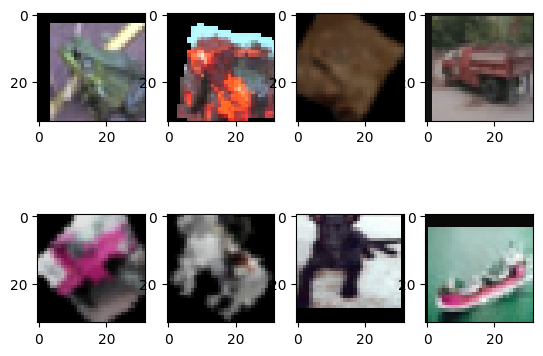

Epoch 1 of 25 took 102.494s
  training loss (in-iteration): 	1.730413
  validation accuracy: 			52.92 %
Epoch 2 of 25 took 101.057s
  training loss (in-iteration): 	1.440046
  validation accuracy: 			61.71 %
Epoch 3 of 25 took 97.948s
  training loss (in-iteration): 	1.291109
  validation accuracy: 			65.21 %
Epoch 4 of 25 took 100.310s
  training loss (in-iteration): 	1.195000
  validation accuracy: 			68.34 %
Epoch 5 of 25 took 99.963s
  training loss (in-iteration): 	1.106446
  validation accuracy: 			72.62 %
Epoch 6 of 25 took 97.551s
  training loss (in-iteration): 	1.048510
  validation accuracy: 			74.24 %
Epoch 7 of 25 took 96.428s
  training loss (in-iteration): 	0.998559
  validation accuracy: 			73.50 %
Epoch 8 of 25 took 99.430s
  training loss (in-iteration): 	0.957645
  validation accuracy: 			73.70 %
Epoch 9 of 25 took 98.048s
  training loss (in-iteration): 	0.920707
  validation accuracy: 			78.77 %
Epoch 10 of 25 took 100.285s
  training loss (in-iteration): 	0.892033

In [35]:
# Training Phase
import time
num_epochs = 25
batch_size  # number of samples processed in one iteration

# Optimizer
opt = torch.optim.AdamW(v8_model.parameters(), lr=0.0001, weight_decay=0.01)

for epoch in range(num_epochs):
    start_time = time.time()

    # Training mode
    v8_model.train(True)
    train_loss = []
    for batch_idx, (x_batch, y_batch) in enumerate(trainset):
        X_train, y_train = x_batch.to(device), y_batch.to(device)
        # y_train = torch.as_tensor(y_batch, dtype=torch.long).to(device)

        loss = compute_loss(X_train, y_train)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss.append(loss.item())

        if epoch == 0 and batch_idx == 0: # display from only first epoch
            for i, img in enumerate(X_train.cpu().numpy()[:8]):
                img = img.transpose([1, 2, 0]) * stds + means
                img = np.clip(img, 0, 1)
                plt.subplot(2, 4, i+1)
                plt.imshow(img)
            plt.show()

    # Evaluation on validation data
    v8_model.train(False)
    val_accuracy = []
    with torch.no_grad():
        for batch_idx, (x_batch, y_batch) in enumerate(valset):
            if x_batch.size(0) < batch_size:  # Check if batch size is less than expected
                continue  # Skip this iteration
            X_val = torch.as_tensor(x_batch, dtype=torch.float32).to(device)
            y_val = torch.as_tensor(y_batch, dtype=torch.long).to(device)

            logits = v8_model(X_val)
            y_pred = logits.max(1)[1].cpu().numpy()  # Move predictions back to CPU
            val_accuracy.append(np.mean(y_val.cpu().numpy() == y_pred))  # Move ground truth to CPU

        # Print the results for the current epoch
    epoch_time = time.time() - start_time  # Calculate epoch duration
    print(f"Epoch {epoch + 1} of {num_epochs} took {epoch_time:.3f}s")
    print(f"  training loss (in-iteration): \t{np.mean(train_loss):.6f}")  # Print mean training loss for the epoch
    print(f"  validation accuracy: \t\t\t{np.mean(val_accuracy) * 100:.2f} %")  # Print mean validation accuracy for the epoch


#### Model Testing

In [36]:
# Test Phase

v8_model.eval()
test_batch_acc = []

for batch_idx, (X_batch, y_batch) in enumerate(valset):
    X_test = torch.as_tensor(X_batch, dtype=torch.float32).to(device)
    y_test = torch.as_tensor(y_batch).to(device)

    with torch.no_grad():
        logits = v8_model(X_test)

    # Get predictions
    y_pred = logits.argmax(dim=1).cpu().numpy()
    y_test = y_test.cpu().numpy()

    test_batch_acc.append(np.mean(y_test == y_pred))

test_accuracy = np.mean(test_batch_acc)

print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'17. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		84.94 %
Achievement unlocked: 110lvl Warlock!


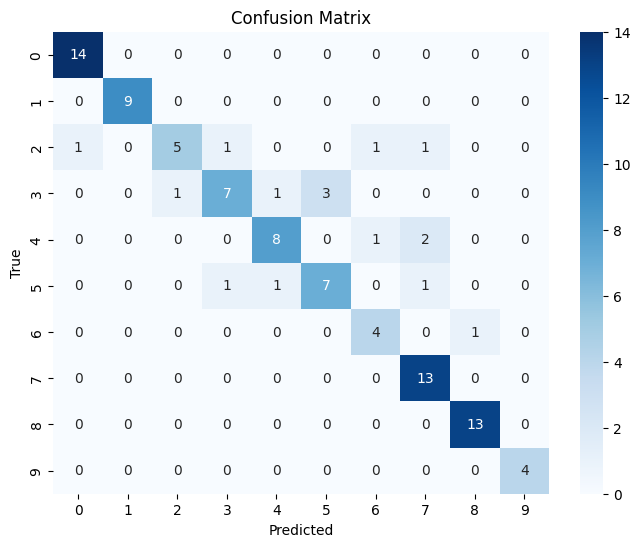

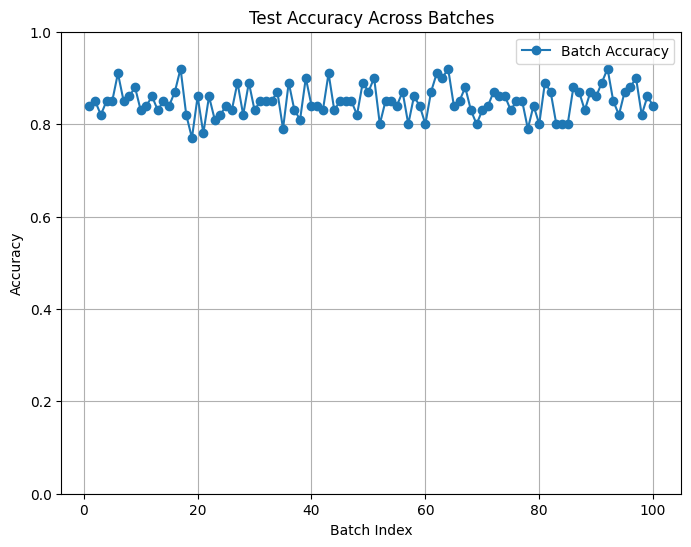

In [37]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = [str(i) for i in range(len(cm))]  # Adjust for number of classes

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix.png')  # Save the chart
plt.show()

# Simulate test accuracy trends over batches for a line plot
batch_indices = range(1, len(test_batch_acc) + 1)
plt.figure(figsize=(8, 6))
plt.plot(batch_indices, test_batch_acc, marker='o', label='Batch Accuracy')
plt.title('Test Accuracy Across Batches')
plt.xlabel('Batch Index')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Accuracy is between 0 and 1
plt.grid(True)
plt.legend()
plt.savefig('accuracy_trend.png')  # Save the chart
plt.show()